In [1]:
from my_functions import*

In [2]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


muon_isolation_all_events: Computing muon isolation: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]
muon_isolation_all_events: Computing muon isolation: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


muon_isolation_all_events: Computing muon isolation: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected


muon_isolation_all_events: Computing muon isolation: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


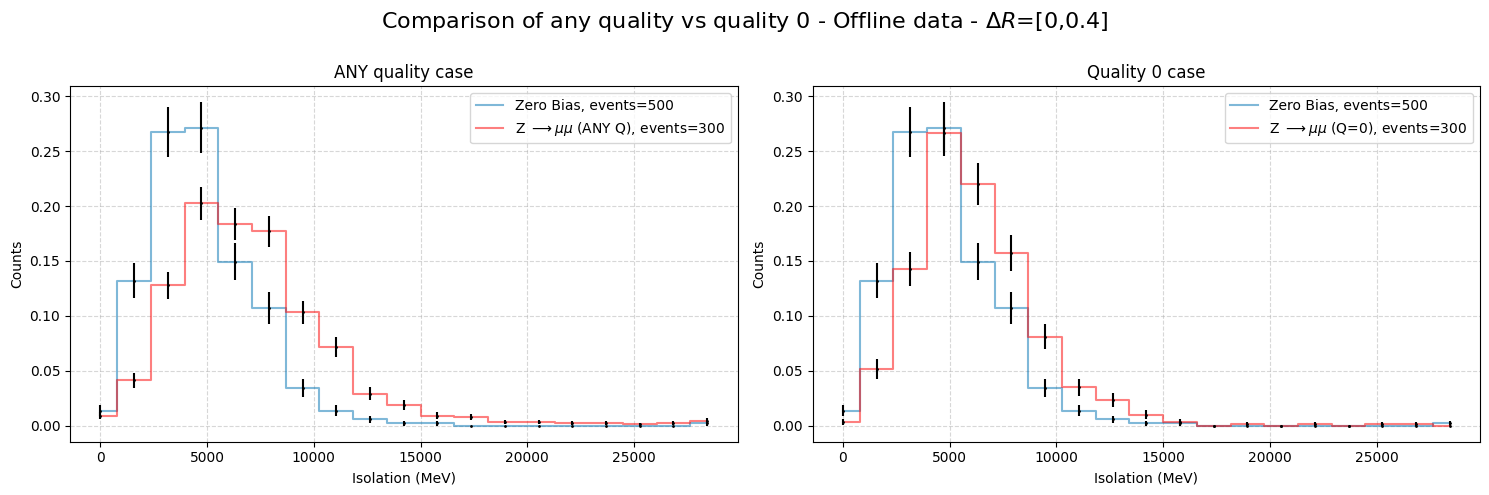

In [3]:


"""
Plots I want to make: 
1. Z mumu vs zero bias
2. All quality vs quality 0 for z mumu
3. Z mumu vs zero bias 0 quality
4. Different dr upper limits and lower limits

5.Repeat for LVL1 and offline
"""

"""
OFFLINE MUON PLOTS
"""

"""
Z -> mu mu vs Zero Bias Offline 
"""


#Assign eta and phi variables Zero Bias
nmin1=0
nmax1=500

ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin1:nmax1]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin1:nmax1]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin1:nmax1]

#Check how many events are not empty
non_empty_count1 = ak.sum(ak.num(ZeroBias_eta[nmin1:nmax1]) > 0)

#Compute the isolation and prepare it for plotting 
res=muon_isolation_all_events(MuonTree_ZeroBias,ZeroBias_eta,ZeroBias_phi,0.0,0.4,[nmin1,nmax1],500)
data1=ak.flatten(res)

#Assign eta and phi variables Z mu mu
muon_eta_all=MuonTree_Zmumu["muon_eta"].array()
muon_phi_all=MuonTree_Zmumu["muon_phi"].array()
nmin2=0
nmax2=300
#Check how many events are not empty
non_empty_count2 = ak.sum(ak.num(muon_eta_all[nmin2:nmax2]) > 0)

#Compute the isolation and prepare it for plotting 
res=muon_isolation_all_events(MuonTree_Zmumu,muon_eta_all,muon_phi_all,0.0,0.4,[nmin2,nmax2],100)
data2=ak.flatten(res)


"""
Z -> mu mu vs ZeroBias offline QUALITY 0
"""

#Assign eta and phi variables Zero Bias
nmin3=0
nmax3=500

ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin3:nmax3]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin3:nmax3]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin3:nmax3]

#Check how many events are not empty
non_empty_count3 = ak.sum(ak.num(muon_eta_all[nmin3:nmax3]) > 0)

#Compute the isolation and prepare it for plotting 
res=muon_isolation_all_events(MuonTree_ZeroBias,ZeroBias_eta,ZeroBias_phi,0.0,0.4,[nmin3,nmax3],500)
data3=ak.flatten(res)

#Assign eta and phi variables Z mu mu
muon_eta_all=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)
muon_phi_all=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)
nmin4=0
nmax4=300
#Check how many events are not empty
non_empty_count4 = ak.sum(ak.num(muon_eta_all[nmin4:nmax4]) > 0)

#Compute the isolation and prepare it for plotting 
res=muon_isolation_all_events(MuonTree_Zmumu,muon_eta_all,muon_phi_all,0.0,0.4,[nmin4,nmax4],100)
data4=ak.flatten(res)

"""
I define this functions to plot everything more comfortably and as subplots
"""

def f(i,ax):
    #This line is used to set the axis to the current axis
    plt.sca(ax)
    
    if i==0:
        #Set the colors and labels for the plot
        colors=["#0072B2", "#FD0000"]
        labels=[fr"Zero Bias, events={non_empty_count1}",fr"Z $\longrightarrow \mu \mu$ (ANY Q), events={non_empty_count2}"]

        #Plot the data
        coolplot([data1,data2],
                        np.linspace(0,30000,20),
                        colors,labels,
                        "Isolation (MeV)","Counts",
                "ANY quality case",
                plot_show=False)

    if i==1:
        #Set the colors and labels for the plot
        colors=["#0072B2", "#FD0000"]
        labels=[fr"Zero Bias, events={non_empty_count3}",fr"Z $\longrightarrow \mu \mu$ (Q=0), events={non_empty_count4}"]

        #Plot the data
        coolplot([data3,data4],
                        np.linspace(0,30000,20),
                        colors,labels,
                        "Isolation (MeV)","Counts",
                "Quality 0 case",
                plot_show=False)

def f_subplots():
    # Plot as subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax=ax.flatten()
    #for each lower and upper limit, plot the data
    for i in [0,1]:
        f(i,ax[i])

    fig.suptitle(r"Comparison of any quality vs quality 0 - Offline data - $\Delta R$=[0,0.4]", fontsize=16)  # Set the global title
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to leave space for suptitle
    plt.show()

f_subplots()